C:\Users\Enzo\AppData\Local\Temp\ipykernel_29628\1844618957.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')


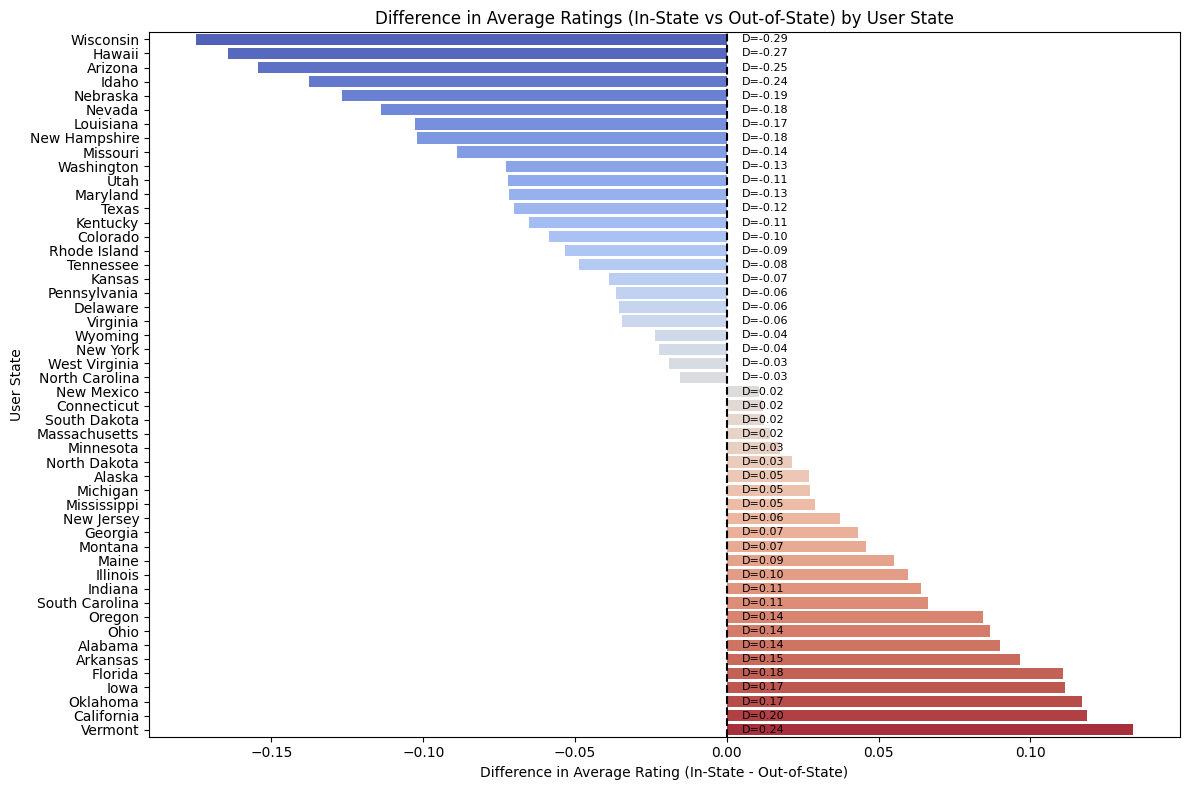

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math



US_ratings = pd.read_csv('data/USData/BA_US_states_all.csv')


def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)  # Using sample standard deviation
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['user_state'].unique()

results = []

for state in unique_states:
    state_users = US_ratings[US_ratings['user_state'] == state].copy()
    
    if state_users.empty:
        continue
    
    state_users['beer_origin'] = np.where(
        state_users['beer_state'] == state, 
        'In-State Beer', 
        'Out-of-State Beer'
    )
    
    in_state_ratings = state_users[state_users['beer_origin'] == 'In-State Beer']['rating']
    out_of_state_ratings = state_users[state_users['beer_origin'] == 'Out-of-State Beer']['rating']
    
    if in_state_ratings.empty or out_of_state_ratings.empty:
        continue
    
    average_in_state = in_state_ratings.mean()
    average_out_of_state = out_of_state_ratings.mean()
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    
    rating_diff = average_in_state - average_out_of_state
    
    results.append({
        'state': state,
        'average_in_state': average_in_state,
        'average_out_of_state': average_out_of_state,
        'difference': rating_diff,
        'cohen_d': d_value
    })

state_results = pd.DataFrame(results)
state_results.sort_values(by='difference', inplace=True)  # Sort by difference
state_results.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State")
plt.ylabel("User State")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.axvline(0, color='black', linestyle='--')

for i, row in state_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax.text(text_x, i, d_val, 
            color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()


plt.savefig("modules/8.png")